In [1]:
from tensorflow.keras.datasets import reuters
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 실험1

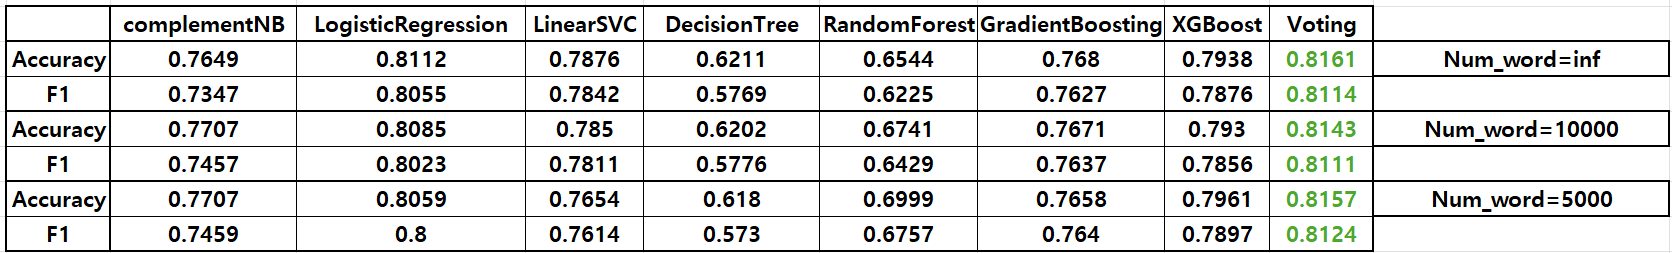

실험결과 가장 높은 점수를 받은 것은 Voting 모델이고, Num_word는 모든 단어를 쓴 모델이 가장 높았다.
하지만 voting 모델의 단어수에 따른 점수 변화 폭이 너무 작기에 무시해도 될 정도라고 생각된다.

따라서 앙상블기법을 쓴 모델이 개별 모델보다 효과적일 수 있음을 알 수 있고, 이 모델은 단어수 변화에 큰 차이가 없어 적은 단어라도 학습에 무리가 없다는 것을 알 수 있다.

# 실험 2

본래의 코드에서 에폭수가 너무 적다고 판단하여 에폭수= 50으로 늘려 실험 진행

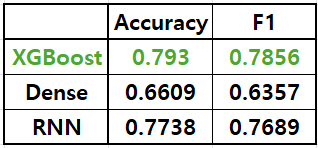

결과는 위와 같고, XGBoost의 점수가 가장 높게 나왔다. 하지만 RNN의 점수는 에폭을 늘릴수록 높아지는 반면 Dense의 점수는 낮아지는 경향을 보였다.

여기서 에폭의 수를 같게하여 실험을 진행하는 것이 맞다 생각되어 50을 기준으로 잡았고, 에폭이 10이든 50이든 XGBoost의 점수가 가장 높다는 사실에는 변함이 없었다.

이를 통해 XGBoost가 딥러닝 모델이 아님에도 불구하고 딥러닝 모델들과 경쟁력이 있다는 사실을 알 수 있고, 딥러닝 모델들의 성능을 개선하기 위해 여러 시도가 더 필요하다는 사실을 알게되었다.

In [2]:
# 이부분에있는 num_words를 5000과 다른방법으로 바꿔보세요~

(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2) ##

In [3]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [4]:
index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [5]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [6]:
decoded_test = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded_test.append(t)

x_test = decoded_test
print(len(x_test))

2246


In [7]:
# 벡터화 DTM, TF-idf 방법
dtmvector = CountVectorizer()

tfidf_transformer = TfidfTransformer()

x_train_dtm = dtmvector.fit_transform(x_train)
x_test_dtm= dtmvector.transform(x_test)

x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

In [8]:
# 벡터화 W2V방법
from gensim.models import Word2Vec

# 우선 문장을 토큰화 시킵시다 띄어쓰기 기반으로 해볼게요! -> # 위에서 DTM만들때는 왜 안해줬냐! -> CountVectorizer에서 띄어쓰기 기반 토큰화가 내장되있음
x_train_tokenized = [sentence.split() for sentence in x_train]
x_test_tokenized = [sentence.split() for sentence in x_test]

# vector사이즈를 늘리거나 줄여보세요 아마 512 가장많이쓰이는 방식
model = Word2Vec(sentences = x_train_tokenized, vector_size = 256, window = 5, min_count = 5, workers = 4, sg = 0)
print("모델 학습 완료!")

모델 학습 완료!


In [9]:
w2v_model = model

# 각 문장을 벡터화 시키는 코드
def vectorize_sentence(sentence, model, max_len):
    vecs = []
    for word in sentence:
        if word in model.wv:
            vecs.append(model.wv[word])
        else:
            vecs.append(np.zeros(model.vector_size))
    # Padding
    if len(vecs) < max_len:
        vecs += [np.zeros(model.vector_size)] * (max_len - len(vecs))
    else:
        vecs = vecs[:max_len]
    return np.array(vecs)


In [10]:
x_train_w2v = np.array([vectorize_sentence(s, w2v_model, max_len=100) for s in x_train_tokenized])
x_test_w2v = np.array([vectorize_sentence(s, w2v_model, max_len=100) for s in x_test_tokenized])

In [11]:
from xgboost import XGBClassifier

# XGBoost 모델 학습
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, eval_metric='mlogloss')
xgb_model.fit(x_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [12]:
# 예측
y_pred = xgb_model.predict(x_test_tfidf)

# 평가 지표
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.7930
✅ F1-score : 0.7856


In [13]:
# Word2Vec 임베딩 시퀀스: (8982, 100, 256)
x_w2v_seq_train = x_train_w2v
x_w2v_seq_test = x_test_w2v
# 평균 풀링 → (8982, 256)
x_w2v_avg_train = np.mean(x_w2v_seq_train, axis=1)
x_w2v_avg_test = np.mean(x_w2v_seq_test, axis=1)
print(x_w2v_avg_train.shape)  # (8982, 256)

(8982, 256)


In [14]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, eval_metric='mlogloss')
xgb_model.fit(x_w2v_avg_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [15]:
# 예측
y_pred = xgb_model.predict(x_w2v_avg_test)

# 평가 지표
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, Dense, Dropout


dense_model = Sequential([
    Flatten(input_shape=(100, 256)),  # (seq_len, embedding_dim)
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(46, activation='softmax')   # 클래스 수에 맞게 조정 46개로 맞춰주세요!
])

dense_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense_model.summary()

C:\ananconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      13,107,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 46)                  │           5,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,179,310 (50.28 MB)

 Trainable params: 13,179,310 (50.28 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
dense_model.fit(x_train_w2v, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.5167 - loss: 2.2226 - val_accuracy: 0.6594 - val_loss: 1.4878
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.6730 - loss: 1.3687 - val_accuracy: 0.6639 - val_loss: 1.4312
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.7295 - loss: 1.0740 - val_accuracy: 0.6867 - val_loss: 1.3841
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.7767 - loss: 0.8908 - val_accuracy: 0.6817 - val_loss: 1.4569
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.8225 - loss: 0.7230 - val_accuracy: 0.6839 - val_loss: 1.4284
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.8394 - loss: 0.6556 - val_accuracy: 0.6828 - val_loss: 1.5443
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.8428 - loss: 0.6116 - val_accuracy: 0.6828 - val_loss: 1.5119
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.8670 - loss: 0.5192 - 

In [51]:
y_pred_proba = dense_model.predict(x_test_w2v)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
✅ Accuracy: 0.6812
✅ F1-score: 0.6605


In [20]:
rnn_model = Sequential([
    LSTM(128, input_shape=(100, 256)),  # (seq_len, embedding_dim)
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(46, activation='softmax')   # 클래스 수에 맞게 조정 46개로 맞춰주세요~
])

rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()

C:\ananconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 46)                  │           2,990 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,366 (813.93 KB)

 Trainable params: 208,366 (813.93 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
rnn_model.fit(x_train_w2v, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - accuracy: 0.9047 - loss: 0.3592 - val_accuracy: 0.7796 - val_loss: 1.2118
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - accuracy: 0.9000 - loss: 0.3832 - val_accuracy: 0.7863 - val_loss: 1.1887
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.9082 - loss: 0.3567 - val_accuracy: 0.7941 - val_loss: 1.2180
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.9151 - loss: 0.3113 - val_accuracy: 0.7880 - val_loss: 1.2200
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - accuracy: 0.9113 - loss: 0.3095 - val_accuracy: 0.7869 - val_loss: 1.2223
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.9142 - loss: 0.3284 - val_accuracy: 0.7846 - val_loss: 1.2576
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 116ms/step - accuracy: 0.9055 - loss: 0.3572 - val_accuracy: 0.7858 - val_loss: 1.2630
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - accuracy: 0.9140 - loss: 0.314

In [43]:
y_pred_proba = rnn_model.predict(x_test_w2v)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
✅ Accuracy: 0.7738
✅ F1-score: 0.7689


In [23]:
(x_tr, y_tr), (x_te, y_te) = reuters.load_data(num_words=None, test_split=0.2)

In [24]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [25]:
decoded = []
for i in range(len(x_tr)):
    t = ' '.join([index_to_word[index] for index in x_tr[i]])
    decoded.append(t)

x_tr = decoded
print(len(x_tr))

decoded = []
for i in range(len(x_te)):
    t = ' '.join([index_to_word[index] for index in x_te[i]])
    decoded.append(t)

x_te = decoded
print(len(x_te))

8982
2246


In [26]:
dtmvector = CountVectorizer()

tfidf_transformer = TfidfTransformer()

x_tr_dtm = dtmvector.fit_transform(x_tr)
x_te_dtm= dtmvector.transform(x_te)

x_tr_tfidf = tfidf_transformer.fit_transform(x_tr_dtm)
x_te_tfidf = tfidf_transformer.transform(x_te_dtm)

In [27]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,f1_score #정확도 계산

In [32]:
# 개별 모델 정의
cb = ComplementNB()
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000, random_state=0)
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False, random_state=0)
dt = DecisionTreeClassifier(max_depth=10, random_state=0)
rf = RandomForestClassifier(n_estimators=5, random_state=0)
grbt = GradientBoostingClassifier(random_state=0) # verbose=3: 진행 상황 확인 가능
xgb = XGBClassifier(n_estimators=100, max_depth=5, eval_metric='mlogloss')

# Soft voting
voting_classifier = VotingClassifier(
    estimators = [
        ('lr', lr),
        ('nb', cb),
        ('gb', grbt)
    ],
    voting='soft',
    n_jobs=-1
)

In [33]:
cb.fit(x_tr_tfidf, y_tr)

predicted = cb.predict(x_te_tfidf) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_te, predicted)) #예측값과 실제값 비교
print("f1 score:", f1_score(y_te, predicted, average='weighted'))

정확도: 0.7649154051647373
f1 score: 0.7346534179503126


In [34]:
# 10분 정도 소요됩니다.
lr.fit(x_tr_tfidf, y_tr)

predicted = lr.predict(x_te_tfidf) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_te, predicted)) #예측값과 실제값 비교
print("f1 score:", f1_score(y_te, predicted, average='weighted'))

정확도: 0.811219946571683
f1 score: 0.805548394682704


In [35]:
lsvc.fit(x_tr_tfidf, y_tr)

predicted = lsvc.predict(x_te_tfidf) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_te, predicted)) #예측값과 실제값 비교
print("f1 score:", f1_score(y_te, predicted, average='weighted'))

정확도: 0.7876224398931434
f1 score: 0.782427719782083


C:\ananconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [36]:
dt.fit(x_tr_tfidf, y_tr)

predicted = dt.predict(x_te_tfidf) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_te, predicted)) #예측값과 실제값 비교
print("f1 score:", f1_score(y_te, predicted, average='weighted'))

정확도: 0.6211041852181657
f1 score: 0.5769283128518847


In [37]:
rf.fit(x_tr_tfidf, y_tr)

predicted = rf.predict(x_te_tfidf) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_te, predicted)) #예측값과 실제값 비교
print("f1 score:", f1_score(y_te, predicted, average='weighted'))

정확도: 0.6544968833481746
f1 score: 0.6225909375608356


In [38]:
grbt.fit(x_tr_tfidf, y_tr)

predicted = grbt.predict(x_te_tfidf) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_te, predicted)) #예측값과 실제값 비교
print("f1 score:", f1_score(y_te, predicted, average='weighted'))

정확도: 0.7680320569902048
f1 score: 0.7627808003795614


In [39]:
xgb.fit(x_tr_tfidf, y_train)

predicted = xgb.predict(x_te_tfidf) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_te, predicted)) #예측값과 실제값 비교
print("f1 score:", f1_score(y_te, predicted, average='weighted'))

정확도: 0.7938557435440784
f1 score: 0.7876948392376837


In [40]:
voting_classifier.fit(x_tr_tfidf, y_tr)

predicted = voting_classifier.predict(x_te_tfidf) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_te, predicted)) #예측값과 실제값 비교
print("f1 score:", f1_score(y_te, predicted, average='weighted'))

정확도: 0.8161175422974176
f1 score: 0.8114868325185072
